# Артём Юдин

<div class="alert alert-block alert-info">
<b>Навигация по главам</b> не будет работать на <b>GitHub</b>. Скачайте .ipynb файл. 

Если навигация будет по прежнему <i>странно</i> работать, закройте вкладку с ноутбуком и откройте снова
</div>

# Chapters <a class="anchor" id="chapters"></a>
0. [Import](#import)
1. [Работа с данными](#data)
      1. [Считываем данные](#read)
      2. [Работа с картами](#maps)
      3. [Перенос фич в трейн](#feachs)
      4. [Подготовка данных к обучению](#preproc)
2. [Работа с моделями](#models)
      1. [LightGBM](#lgb)
      2. [XGBoost](#xgb)
      3. [CatBoost](#cb)
      4. [Linear Regression](#lin)
      5. [Lasso](#lasso)
      6. [Ridge](#ridge)
      7. [Torch](#torch)

# 0. [Import](#chapters) <a class="anchor" id="import"></a>

In [3]:
# основные библиотеки для исследования данных
import numpy as np
import pandas as pd
import plotly.express as px

# ML библиотеки, которые мы будем использовать для регрессии
import catboost as cb
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression, Lasso, Ridge

# DL библиотеки, с которыми мы также построим линейную модель
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import lightning as L

# функции для предобработки и оценки
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# подбор гиперпараметров для ML
import optuna

# выключаем ненужное логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)  
import warnings
warnings.filterwarnings('ignore')

# 1. [Работа с данными](#chapters) <a class="anchor" id="data"></a>

## 1.1 [Считывание данных](#chapters) <a class="anchor" id="read"></a>

In [4]:
train_df = pd.read_csv('./datasets/train.csv')
test_df = pd.read_csv('./datasets/test.csv')
features_df = pd.read_csv('./datasets/features.csv')

features = list((str(x) for x in range(363))) # поскольку у нас фичи 0-362, создадим массив для последующего извлечения

## 1.2 [Работа с картами](#chapters) <a class="anchor" id="maps"></a>

Посмотрим на карте, где находястя наши объекты недвижимости

In [5]:
fig = px.scatter_mapbox(train_df, lat="lat", lon="lon", #color='score',
                        color_continuous_scale="RdYlGn_r", zoom=3,
                        mapbox_style="carto-positron", height=1000)
fig.update_layout(margin=dict(l=0, r=0, t=30, b=10))
fig.show()

Так, они разбросаны по всей России. Теперь посмотрим распределние по "привлекательности"

<Axes: >

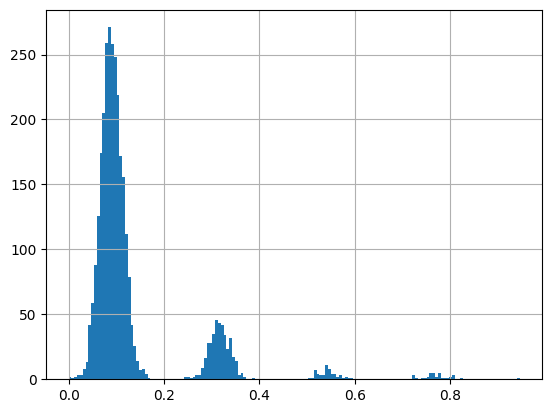

In [6]:
train_df['score'].hist(bins=160)

Не очень приятная ситуация

Теперь посмотрим, как там дела с нашими фичами, может их где-то нет из уже известных точек

In [8]:
fig = px.scatter_mapbox(features_df, lat="lat", lon="lon",
                        color_continuous_scale="RdYlGn_r", zoom=3,
                        mapbox_style="carto-positron", height=1000)
fig.update_layout(margin=dict(l=0, r=0, t=30, b=10))
fig.show()

Изобразим на одной карте и обучающие объекты, и фичи

In [9]:
train_df['is_train'] = 1
features_df['is_train'] = 0

train_with_features = pd.concat([features_df[['lon', 'lat', 'is_train']], train_df[['lon', 'lat', 'is_train']]], ignore_index=True)
train_with_features

,lon,lat,is_train
0,30.262701,59.837100,0
1,30.274201,59.935705,0
2,30.419863,59.929714,0
3,40.356119,56.111227,0
4,43.872728,56.233351,0
...,...,...,...
6780,37.279505,55.674584,1
6781,49.188791,55.784909,1
6782,61.462996,55.118828,1
6783,37.533877,55.649052,1


In [10]:
fig = px.scatter_mapbox(train_with_features, lat="lat", lon="lon", color='is_train',
                        color_continuous_scale="RdYlGn_r", zoom=3,
                        mapbox_style="carto-positron", height=1000)
fig.update_layout(margin=dict(l=0, r=0, t=30, b=10))
fig.show()

## 1.3 [Перенос фич в трейн](#chapters) <a class="anchor" id="feachs"></a>

У нас есть огромное количество объектов, которые находятся буквально рядом друг с другом. Найдём расстояние от каждой точки из train до каждой точки из features и возьмём фичи самого близкого объекта

In [11]:
geo1 = np.atleast_2d(train_df[['lat', 'lon']]).reshape(1,-1,2)
geo2 = np.atleast_2d(features_df[['lat', 'lon']]).reshape(-1,1,2)

p = np.power(geo1-geo2, 2).sum(axis=2).argmin(axis = 0) # рассчитываем евклидово расстояние без корня

train_df.loc[:, features] = features_df.loc[p, features].reset_index(drop=True)

Как теперь выглядит train

In [13]:
train_df

,id,lat,lon,score,is_train,0,1,2,3,4,...,353,354,355,356,357,358,359,360,361,362
0,0,56.228300,43.945535,0.080523,1,0.142355,0.144008,0.201290,0.145479,0.124842,...,0.040666,0.046229,0.043170,0.037397,0.006636,0.006988,0.042022,0.046229,0.030355,0.028775
1,1,56.834244,53.141543,0.104424,1,0.094093,0.096425,0.161355,0.089489,0.106608,...,0.044782,0.050457,0.112922,0.118146,0.015303,0.005454,0.046132,0.050457,0.079399,0.090907
2,2,45.042299,41.990170,0.067615,1,0.151723,0.148761,0.329598,0.159483,0.145691,...,0.067001,0.069333,0.088930,0.103357,0.016793,0.004943,0.068319,0.069333,0.062530,0.079528
3,3,59.849408,30.387762,0.088038,1,0.423663,0.289528,0.411117,0.516551,0.429777,...,0.039954,0.041455,0.144839,0.146129,0.013272,0.005454,0.041311,0.041455,0.101842,0.112438
4,4,59.839643,30.304308,0.099686,1,0.489140,0.361624,0.538862,0.546345,0.504863,...,0.049272,0.059523,0.138435,0.126554,0.016522,0.010568,0.050615,0.059523,0.097339,0.097376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3079,3079,55.674584,37.279505,0.531557,1,0.628328,0.508291,0.496949,0.788273,0.614644,...,0.053256,0.075838,0.116024,0.094795,0.008803,0.004943,0.054594,0.075838,0.081581,0.072940
3080,3080,55.784909,49.188791,0.101631,1,0.193135,0.209952,0.328156,0.184800,0.167313,...,0.040777,0.051746,0.052035,0.045472,0.010157,0.006988,0.042133,0.051746,0.036588,0.034988
3081,3081,55.118828,61.462996,0.125265,1,0.127627,0.114175,0.276783,0.137704,0.127110,...,0.059907,0.063839,0.124747,0.113721,0.020585,0.005284,0.061235,0.063839,0.087714,0.087502
3082,3082,55.649052,37.533877,0.322601,1,0.663058,0.691683,0.660638,0.697755,0.582316,...,0.027110,0.047115,0.126860,0.137346,0.005823,0.002386,0.028485,0.047115,0.089200,0.105680


## 1.4 [Подготовка данных к обучению](#chapters) <a class="anchor" id="preproc"></a>

Нормализуем данные с помощью StandardScaler

In [14]:
sc = StandardScaler()
sc.fit(train_df[features])
train_scaled = pd.DataFrame(sc.transform(train_df[features]))
train_scaled.loc[:, ['lon', 'lat', 'score']] = train_df.loc[:, ['lon', 'lat', 'score']].reset_index(drop=True)

In [15]:
train_scaled

,0,1,2,3,4,5,6,7,8,9,...,356,357,358,359,360,361,362,lon,lat,score
0,-0.728351,-0.664652,-1.030451,-0.733615,-0.774493,-0.710787,-0.452285,-0.830783,-0.667493,-0.853236,...,-0.724862,-0.459308,-0.390465,-0.534512,-0.552319,-0.696420,-0.721263,43.945535,56.228300,0.080523
1,-0.947045,-0.905343,-1.312223,-0.947285,-0.862466,-0.939961,-0.960939,0.487171,-0.823532,0.381541,...,-0.253778,-0.391538,-0.409428,-0.505464,-0.521977,-0.459908,-0.442186,53.141543,56.834244,0.104424
2,-0.685900,-0.640610,-0.125121,-0.680173,-0.673908,-0.689002,-0.224414,0.039399,0.877113,-0.575573,...,-0.340054,-0.379890,-0.415749,-0.348657,-0.386523,-0.541259,-0.493297,41.990170,45.042299,0.067615
3,0.546384,0.071438,0.450070,0.682476,0.696682,0.546070,0.354883,1.680721,0.374349,-0.262467,...,-0.090530,-0.407421,-0.409428,-0.539541,-0.586582,-0.351682,-0.345476,30.387762,59.849408,0.088038
4,0.843087,0.436124,1.351425,0.796175,1.058940,0.974656,-0.091295,1.294930,-0.542218,2.060186,...,-0.204728,-0.382008,-0.346219,-0.473781,-0.456922,-0.373397,-0.413128,30.304308,59.839643,0.099686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3079,1.473813,1.178024,1.055690,1.719425,1.588581,1.410888,1.058450,0.342412,0.040223,-0.375282,...,-0.390003,-0.442365,-0.415749,-0.445664,-0.339846,-0.449389,-0.522888,37.279505,55.674584,0.531557
3080,-0.498244,-0.331086,-0.135297,-0.583557,-0.569592,-0.454993,-0.642709,0.615858,0.519154,-0.453709,...,-0.677751,-0.431776,-0.390465,-0.533729,-0.512733,-0.666361,-0.693354,49.188791,55.784909,0.101631
3081,-0.795091,-0.815562,-0.497780,-0.763286,-0.763552,-0.829996,-0.934065,0.739553,0.406563,-0.240749,...,-0.279593,-0.350240,-0.411535,-0.398724,-0.425949,-0.419810,-0.457480,61.462996,55.118828,0.125265
3082,1.631192,2.105684,2.210662,1.373988,1.432615,1.677336,1.394002,-0.026752,0.459351,0.825409,...,-0.141769,-0.465661,-0.447354,-0.630183,-0.545963,-0.412645,-0.375830,37.533877,55.649052,0.322601


Подготовим данные для обучения на них моделей

In [16]:
train_scaled.columns = train_scaled.columns.astype(str)

X_train, X_val, y_train, y_val = train_test_split(train_scaled.drop('score',axis=1), 
                                                  train_scaled['score'],
                                                  random_state=42,
                                                  test_size=0.2
)

# 2. [Работа с моделями](#chapters) <a class="anchor" id="models"></a>

Будем подбирать гиперпараметры по моделям, затем выберим модель с самым низким МАЕ.

## 2.1 [LightGBM](#chapters) <a class="anchor" id="lgb"></a>

In [17]:
def objective(trial):
    # получаем данные, на которых будет осуществляться подгон
    train_x, val_x, train_y, val_y = train_test_split(train_scaled.drop('score',axis=1), 
                                                      train_scaled['score'], 
                                                      random_state=42, 
                                                      test_size=0.2)
    
    # список гиперпараметров модели, которые мы будем использовать
    param = {
        "objective": "regression_l1",
        "metric": "l1",
        "verbosity": -1,
        "random_state": 42,
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 10, log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "num_iterations": trial.suggest_int("num_iterations", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 1, 18),
        "num_leaves": trial.suggest_int("num_leaves", 2, 400),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    # рассчитываем ошибку
    gbm = lgb.LGBMRegressor(**param)
    gbm.fit(train_x, train_y)
    preds = gbm.predict(val_x)
    mae = mean_absolute_error(val_y, preds)

    return mae

# создаём обучение с целью минимизировать MAE модели за 50 прогонов
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=50, n_jobs=4, show_progress_bar=True)
trial = study.best_trial

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

  0%|          | 0/50 [00:00<?, ?it/s]

  Params: 
    learning_rate: 0.02656021816583653
    lambda_l1: 2.4819045842659324e-06
    lambda_l2: 0.17941857237883563
    feature_fraction: 0.5384749572183165
    bagging_fraction: 0.9986903735606857
    bagging_freq: 3
    num_iterations: 328
    max_depth: 16
    num_leaves: 187
    min_child_samples: 20


## 2.2 [XGBoost](#chapters) <a class="anchor" id="xgb"></a>

In [18]:
def objective(trial):
    # получаем данные, на которых будет осуществляться подгон
    train_x, val_x, train_y, val_y = train_test_split(train_scaled.drop('score',axis=1), 
                                                      train_scaled['score'], 
                                                      random_state=42, 
                                                      test_size=0.2)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(val_x, label=val_y)

    # список гиперпараметров модели, которые мы будем использовать
    param = {
        "verbosity": 0,
        "eval_metric": "mae",
        "random_state": 42,
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "eta": trial.suggest_float("eta", 1e-8, 10, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 17),
        "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
        "max_leaves": trial.suggest_int("max_leaves", 2, 400),
        "booster": trial.suggest_categorical("booster", ["gbtree","dart"]),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
    }

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    # рассчитываем ошибку
    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    mae = mean_absolute_error(val_y, preds)
    return mae

# создаём обучение с целью минимизировать MAE модели за 50 прогонов
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=50, n_jobs=4, show_progress_bar=True)
trial = study.best_trial

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

  0%|          | 0/50 [00:00<?, ?it/s]

  Params: 
    lambda: 5.0190366391729435e-05
    alpha: 0.0073147923295722615
    subsample: 0.7683629290509952
    colsample_bytree: 0.9476725252832774
    eta: 0.2083560788577709
    gamma: 4.914220184235843e-07
    n_estimators: 414
    max_depth: 12
    min_child_weight: 2
    max_leaves: 55
    booster: gbtree
    grow_policy: depthwise


## 2.3 [CatBoost](#chapters) <a class="anchor" id="cb"></a>

С CatBoost оказалось сложнее, поэтому прогоним его без подгона гиперпараметров по примерно похожим на предыдущие значения

In [19]:
pool_train = cb.Pool(X_train, y_train)
pool_test = cb.Pool(X_val)

cbr = cb.CatBoostRegressor(random_seed=42,
                           iterations=100, 
                           max_depth=12,
                           verbose=1,
                           loss_function="MAE"
                          )
cbr.fit(pool_train)
preds = cbr.predict(pool_test)
mean_absolute_error(y_val, preds)

0:	learn: 0.0600978	total: 2.03s	remaining: 3m 21s
1:	learn: 0.0594711	total: 4.02s	remaining: 3m 17s
2:	learn: 0.0589681	total: 5.98s	remaining: 3m 13s
3:	learn: 0.0584306	total: 8.02s	remaining: 3m 12s
4:	learn: 0.0579368	total: 9.99s	remaining: 3m 9s
5:	learn: 0.0575476	total: 11.9s	remaining: 3m 6s
6:	learn: 0.0569950	total: 13.9s	remaining: 3m 4s
7:	learn: 0.0565391	total: 15.9s	remaining: 3m 2s
8:	learn: 0.0561956	total: 17.9s	remaining: 3m 1s
9:	learn: 0.0559049	total: 19.9s	remaining: 2m 59s
10:	learn: 0.0556003	total: 21.9s	remaining: 2m 56s
11:	learn: 0.0551059	total: 24.1s	remaining: 2m 56s
12:	learn: 0.0546729	total: 26.3s	remaining: 2m 56s
13:	learn: 0.0543153	total: 28.4s	remaining: 2m 54s
14:	learn: 0.0538600	total: 30.4s	remaining: 2m 52s
15:	learn: 0.0532579	total: 32.3s	remaining: 2m 49s
16:	learn: 0.0529071	total: 34.3s	remaining: 2m 47s
17:	learn: 0.0524704	total: 36.3s	remaining: 2m 45s
18:	learn: 0.0521442	total: 38.3s	remaining: 2m 43s
19:	learn: 0.0516556	total:

0.053774957123494144

## 2.4 [Linear Regression](#chapters) <a class="anchor" id="lin"></a>

In [21]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
preds = lin_reg.predict(X_val)
mean_absolute_error(y_val, preds)

0.08264529266537328

## 2.5 [Lasso](#chapters) <a class="anchor" id="lasso"></a>

L1 Линейная регрессия

In [22]:
lasso = Lasso()
lasso.fit(X_train, y_train)
preds = lasso.predict(X_val)
mean_absolute_error(y_val, preds)

0.07223999129246304

## 2.6 [Ridge](#chapters) <a class="anchor" id="ridge"></a>

L2 Линейная регрессия

In [23]:
ridge = Ridge()
ridge.fit(X_train, y_train)
preds = ridge.predict(X_val)
mean_absolute_error(y_val, preds)

0.0756111541957451

## 2.7 [Torch](#chapters) <a class="anchor" id="torch"></a>

Теперь попробуем построить торч модель. Создадим датамодель, которая будет делать ту же самую предобработку данных, разбивать их на бачи и прочее.

In [24]:
class GeoDataset(Dataset):
    def __init__(self, df_x, df_y):
        self.df_x = df_x.to_numpy()
        self.df_y = df_y.to_numpy()

    def __getitem__(self, idx):
        x = self.df_x[idx]
        y = self.df_y[idx]
        return x, y

    def __len__(self):
        return len(self.df_x)


class GeoDataModule(L.LightningDataModule):
    def __init__(
        self,
        train_csv: str = "path/to/file.csv",
        features_csv: str = "path/to/file.csv",
        batch_size: int = 8,
        split_ratio=0.8,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.batch_size = batch_size
        self.split_ratio = split_ratio
        self.train_csv = train_csv
        self.features_csv = features_csv
        self.prepare_data_per_node = False

    def prepare_data(self):
        pass

    def setup(self, stage: str):
        train_df = pd.read_csv(self.train_csv)
        features_df = pd.read_csv(self.features_csv)

        features = list((str(x) for x in range(363)))

        geo1 = np.atleast_2d(train_df[['lat', 'lon']]).reshape(1,-1,2)
        geo2 = np.atleast_2d(features_df[['lat', 'lon']]).reshape(-1,1,2)

        p = np.power(geo1-geo2, 2).sum(axis=2).argmin(axis = 0)

        train_df.loc[:, features] = features_df.loc[p, features].reset_index(drop=True)

        sc = StandardScaler()
        sc.fit(train_df[features])
        train_scaled = pd.DataFrame(sc.transform(train_df[features]))
        train_scaled.loc[:, ['lon', 'lat', 'score']] = train_df.loc[:, ['lon', 'lat', 'score']].reset_index(drop=True)
        
        X_train, X_val, y_train, y_val = train_test_split(train_scaled.drop('score',axis=1), 
                                                  train_scaled['score'],
                                                  random_state=42,
                                                  test_size=0.2
        )
        self.train_set = (X_train, y_train)
        self.val_set = (X_val, y_val)

    def train_dataloader(self):
        train_df = GeoDataset(*self.train_set)
        return DataLoader(train_df, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        val_df = GeoDataset(*self.val_set)
        return DataLoader(val_df, batch_size=self.batch_size, shuffle=False)

Теперь создадим саму модель, она не сильно сложная, всего лишь 4 линейных полносвязанных слоя

In [25]:
class Regressor(L.LightningModule):
    def __init__(self, input_shape: int, lr: float) -> None:
        super().__init__()
        self.lr = lr

        self.block = nn.Sequential(
            nn.Linear(input_shape, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 1),
        ).double()
    
    def forward(self, X:torch.Tensor) -> torch.Tensor:
        return self.block(X)
    
    def _shared_step(self, batch: list[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        feature, target = batch
        logits = self.forward(feature)
        loss = F.l1_loss(logits.reshape(-1), target)
        
        return loss

    def training_step(self, batch: list[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        loss = self._shared_step(batch)

        self.log(
            "train_mae", loss, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss

    def validation_step(self, batch: list[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        loss = self._shared_step(batch)

        self.log(
            "test_mae", loss, prog_bar=True, on_epoch=True, on_step=False
        )

    
    def configure_optimizers(self):
        opt = optim.AdamW(self.parameters(), lr=self.lr)
        sch = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)
        return [opt],[sch]


Запустим модель на обучение

In [26]:
L.seed_everything(42, workers=True)
lightning_model = Regressor(input_shape=X_train.shape[1], lr=1e-3)
datamodule = GeoDataModule('/kaggle/input/vk-int/datasets/train.csv', '/kaggle/input/vk-int/datasets/features.csv')

trainer = L.Trainer(
    max_epochs=10,
    accelerator="auto",   
    devices="auto",       
    deterministic=True,
)

trainer.fit(
    model=lightning_model,
    datamodule=datamodule
)

2024-03-20 15:18:04.345314: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 15:18:04.345493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 15:18:04.507564: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

По итогу самое низкое значение МАЕ получилось у LightGBM. Запишем значения модели с файлик и используем уже в solution.py